### Install Packages

In [ ]:
%%capture
!pip install --upgrade pip
!pip install openai
!pip install gradio
!pip install json-repair

### Configure OpenAI Client

In [ ]:
from openai import OpenAI
from getpass import getpass
client = OpenAI(api_key=getpass("Your OpenAI Key: "), timeout=10)

### Prettify Json

In [ ]:
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

## Vector store files

Set the resources that can be used by the assistant.

`file_search` tool requires a list of vector store IDs.

### Download Google Docs files from Drive folder.

Authenticate and initialize the Google Drive API client.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Get Files from Drive by Folder ID

`folder_id` is the unique identifier for the folder in the Google Drive link.
It is located between the /folders/ part and the ?usp=drive_link in the URL.

https://drive.google.com/drive/folders/{folder_id}?usp=drive_link


Since file streaming don't support Google Docs, we first download the files locally as .docx.

In [ ]:
def embed_from_drive(folder_id):
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    local_file_paths = []
    for file1 in file_list:
        print('Processing file title: %s, id: %s' % (file1['title'], file1['id']))
        local_path = f"/content/{file1['title']}.docx"

        if 'exportLinks' in file1:
            if 'application/vnd.openxmlformats-officedocument.wordprocessingml.document' in file1['exportLinks']:
                # update type if needed (application/vnd.openxmlformats-officedocument.wordprocessingml.document == .docx)
                export_url = file1['exportLinks']['application/vnd.openxmlformats-officedocument.wordprocessingml.document']
                print(f"Downloading as Word document: {file1['title']}")
                downloaded_file = drive.CreateFile({'id': file1['id']})
                downloaded_file.GetContentFile(local_path, mimetype='application/vnd.openxmlformats-officedocument.wordprocessingml.document')
                local_file_paths.append(local_path)
            else:
                print(f"No Word export available for: {file1['title']}")
        else:
            print(f"Skipping non-Google Docs file: {file1['title']}")

    for path in local_file_paths:
        print(f"Downloaded file: {path}")

    file_streams = [open(path, "rb") for path in local_file_paths]
    return file_streams

### Create Vector Store Object

Create vector store file batch.

In [ ]:
VECTOR_STORE_NAME = "lesson-plan"

In [ ]:
def get_vector_store_id(file_streams):
    vector_store = client.beta.vector_stores.create(name=VECTOR_STORE_NAME)

    file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
        vector_store_id=vector_store.id, files=file_streams
    )

    print("file_batch status",file_batch.status)
    print("file_counts",file_batch.file_counts)

    return vector_store.id

### Retrieve Vector Store Files

In [ ]:
def retrieve_vector_store_files(vector_store_id):
    vector_store_files = client.beta.vector_stores.files.list(
        vector_store_id=vector_store_id
    )
    print(vector_store_files.data)

In [ ]:
def retrieve_vector_store_file(vector_store_id, file_id):
    vector_store_file = client.beta.vector_stores.files.retrieve(
        vector_store_id=vector_store_id,
        file_id=file_id
    )
    show_json(vector_store_file)
    print(client.files.retrieve(file_id))

## Assistants

Define properties.

In [ ]:
ASSISTANT_MODEL = "gpt-4o"
ASSISTANT_NAME = "EduBot"
ASSISTANT_DESCRIPTION = "EduBot is an AI assistant designed to help you create and improve lesson plans, provide teaching suggestions, and guide you through educational content design."
ASSISTANT_INSTRUCTION = """
Welcome to EduBot! Here's how to use it:
1. Start the process: Begin by telling EduBot about the lesson you're planning, including the subject, grade level, and key objectives.
2. Refine your plan: EduBot will help you design the structure of your lesson, offer suggestions for improvement, and provide strategies to engage your students effectively.
3. Finalize your plan: Once the lesson plan is complete, you can review, make adjustments, and get tips for enhancing your teaching experience.
"""
CONVERSATION_STARTER = "Click this button to start creating your lesson plan"

Define structured output schema.

In [ ]:
{
  "type": "json_schema",
  "json_schema": {
    "name": "lesson_plan_response",
    "schema": {
      "type": "object",
      "properties": {
        "current_lesson_plan": {
          "type": "string",
          "description": "The content of the currently generated lesson plan. If the process has not yet entered 'lesson plan design', this value should be an empty string."
        },
        "suggestion": {
          "type": "string",
          "description": "Suggestions for improving the current lesson plan or encouragement for the user, guiding them to the next step."
        },
        "next_step_prompt": {
          "type": "array",
          "items": {
            "type": "array",
            "items": {
              "type": "string"
            }
          },
          "description": "Provides the user with options for the next step in a nested list format, for example [['Proceed to the next step'], ['Add more details']]."
        }
      },
      "required": ["current_lesson_plan", "suggestion", "next_step_prompt"],
      "additionalProperties": False
    },
    "strict": True
  }
}


### Create Assistant

In [ ]:
def create_assistant(vector_store_id):
    assistant = client.beta.assistants.create(
        name=ASSISTANT_NAME,
        description=ASSISTANT_DESCRIPTION,
        instructions=ASSISTANT_INSTRUCTION,
        model=ASSISTANT_MODEL,
        tools=[{"type": "file_search"}],
        tool_resources={'file_search': {'vector_store_ids': [vector_store_id]}},
        response_format=RESPONSE_FORMAT
    )
    show_json(assistant)
    return assistant.id

# create_assistant(vector_store.id)

### Enable Streaming

In [ ]:
from typing_extensions import override
from openai import AssistantEventHandler, OpenAI
from openai.types.beta.threads import Text, TextDelta
from openai.types.beta.threads.runs import ToolCall, ToolCallDelta

class EventHandler(AssistantEventHandler):
  @override
  def on_text_created(self, text: Text) -> None:
    print(f"\nassistant > ", end="", flush=True)

  @override
  def on_text_delta(self, delta: TextDelta, snapshot: Text):
    print(delta.value, end="", flush=True)

  @override
  def on_tool_call_created(self, tool_call: ToolCall):
    print(f"\nassistant > {tool_call.type}\n", flush=True)

### Update Assistant

In [ ]:
def update_assistant(assistant_id):
    assistant = client.beta.assistants.update(
        assistant_id=assistant_id,
        name=ASSISTANT_NAME,
        description=ASSISTANT_DESCRIPTION,
        instructions=ASSISTANT_INSTRUCTION,
        model=ASSISTANT_MODEL,
        tool_resources={'file_search': {'vector_store_ids': [vector_store_id]}},
        response_format=RESPONSE_FORMAT
    )
    show_json(assistant)

### Delete Assistant

In [ ]:
def delete_asst(assistant_id):
    response = client.beta.assistants.delete(assistant_id)
    print(response)

# GPTs Implementation Example (File Search)

### Create assistant if didn't retrieved with current ID.

In [ ]:
assistant_id = ""     # Hardcoded
DRIVE_FOLDER_ID = ""

In [ ]:
try:
  assistant = client.beta.assistants.retrieve(assistant_id)
except Exception as e:
  print(f"Assistant DNE: {e}, create assistant instead.")
  file_streams = embed_from_drive(DRIVE_FOLDER_ID)
  vector_store_id = get_vector_store_id(file_streams)
  print("vector_store_id", vector_store_id)
  assistant_id = create_assistant(vector_store_id)

In [ ]:
ASSISTANT_ID = assistant_id
"ASSISTANT_ID",ASSISTANT_ID

### Import Packages

In [ ]:
from json_repair import repair_json
import json_repair
import json
import gradio as gr

### Define Gradio UI components.

In [ ]:
chatbot = gr.Chatbot(type="messages")
canvas_textbox = gr.Textbox(
    label="Canvas",
    lines=20
)
user_prompt_input = gr.Textbox(
    submit_btn=True
)
quick_response = gr.Dataset(
    samples=[[CONVERSATION_STARTER]],
    components=[user_prompt_input]
)
hidden_list = gr.JSON(
    value=[[]],
    visible=False
)

### Function Definition

In [ ]:
def handle_response(message, history, textbox_content):
    integrated_message = message

    if not (message == CONVERSATION_STARTER or textbox_content == ""):
        integrated_message = f"""
            User's current request:
            {message}

            Please combine the following content:
            {textbox_content}
        """


    thread = client.beta.threads.create()
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=integrated_message,
    )
    full_response = ""
    current_lesson_plan = ""
    suggestion = ""
    next_step_prompt = [[]]

    with client.beta.threads.runs.stream(
        thread_id=thread.id,
        assistant_id=ASSISTANT_ID
    ) as stream:
        for text_delta in stream.text_deltas:
            full_response += text_delta

            repaired_json = json_repair.loads(full_response)
            try:
                current_lesson_plan = repaired_json.get('current_lesson_plan', '')
            except:
                current_lesson_plan = ""
            try:
                suggestion = repaired_json.get('suggestion', '')
            except:
                suggestion = ""

            yield suggestion, current_lesson_plan, [[]]

    try:
        repaired_json = json.loads(full_response)
        next_step_prompt = repaired_json.get('next_step_prompt', [["next step"]])
    except:
        next_step_prompt = [["next step"]]

    yield suggestion, current_lesson_plan, next_step_prompt


def handle_quick_response_click(selected):
    return selected[0]

def handle_quick_response_samples(next_step_prompt):
    if len(next_step_prompt) > 0 and len(next_step_prompt[0]) > 0:
        return gr.Dataset(samples=next_step_prompt,visible=True)
    return gr.Dataset(samples=[['-']],visible=False)

### Gradio UI Layout & Interaction

Setting up a user interface with Gradio, consisting of a left panel for input and a right panel for chat interaction, simulating GPTs function,
with quick response functionality and dynamic updates between the inputs and outputs.

In [ ]:
with gr.Blocks() as demo:
    with gr.Row(equal_height=True):
        with gr.Column():  # Left Column
            canvas_textbox.render()
            user_prompt_inputprompt_input.render()
            quick_response.render()
            hidden_list.render()
        with gr.Column():  # Right Column
            gr.ChatInterface(
                handle_response,
                canvas_textbox=user_prompt_inputprompt_input,
                examples=[[CONVERSATION_STARTER, None]],
                additional_inputs=[canvas_textbox],
                additional_outputs=[canvas_textbox, hidden_list],
                type="messages"
            )

    quick_response.click(              # Auto-fill user prompt with the clicked tag
        handle_quick_response_click,
        quick_response,                # clicked tag value as input
        user_prompt_inputprompt_input  # function return value to user prompt textbox
    )

    hidden_list.change(handle_quick_response_samples, hidden_list, quick_response)

demo.launch(debug=True)

### Gradio UI Screenshot
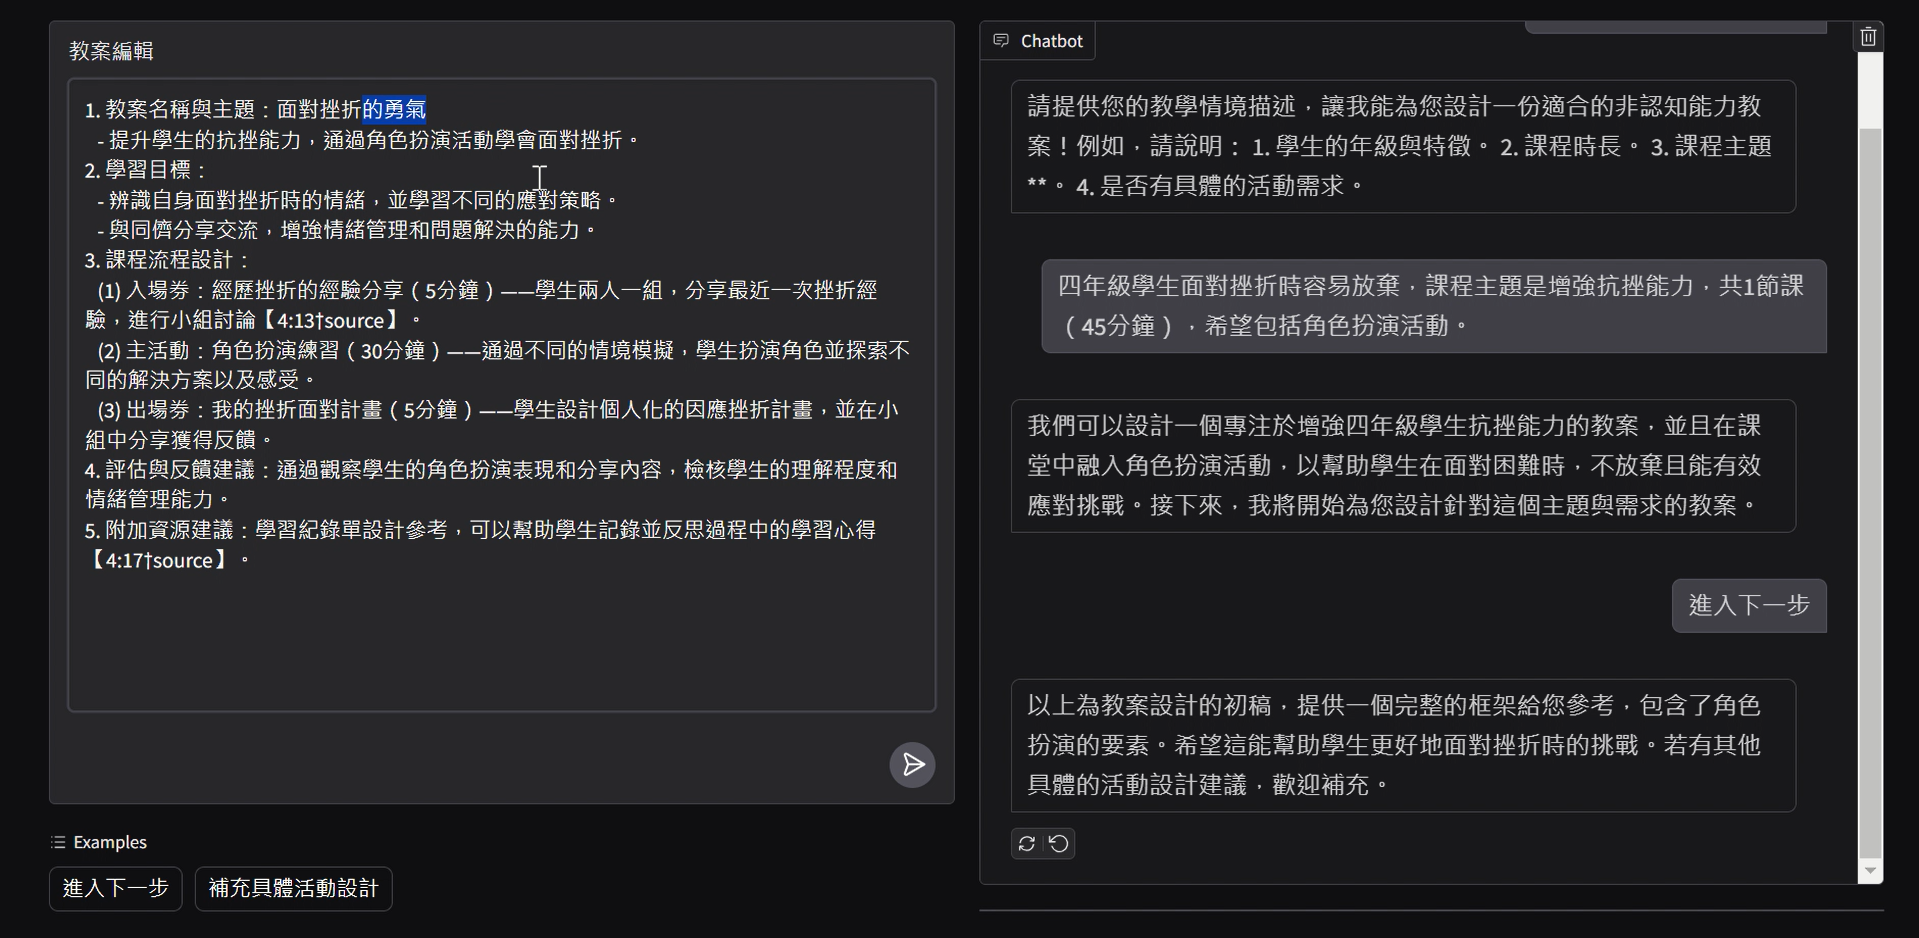